## **Anomaly detection for vibration bearings**

In [3]:
#import package

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as md
from matplotlib.dates import DateFormatter
from numpy.random import seed

#from keras.layers import Input, Dropout
#from keras.layers.core import Dense
#from keras.models import Model, Sequential, load_model
#from keras import regularizers
#from keras.models import model_from_json

In [4]:
#Import dataset

data = pd.read_csv("sensor_data.csv")
fail_dt = pd.read_csv('fail_log.csv')
data

,datetime,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,151.919999,530.813578,101.788175,49.604013
1,2015-01-01 07:00:00,174.522001,535.523532,113.256009,41.515905
2,2015-01-01 08:00:00,146.912822,456.080746,107.786965,42.099694
3,2015-01-01 09:00:00,179.530561,503.469990,108.283817,37.847727
4,2015-01-01 10:00:00,180.544277,371.600611,107.553307,41.467880
...,...,...,...,...,...
8756,2016-01-01 02:00:00,159.528764,319.821957,101.215709,36.846119
8757,2016-01-01 03:00:00,169.933392,278.311273,107.586273,34.658987
8758,2016-01-01 04:00:00,180.448076,383.795163,110.076764,33.067122
8759,2016-01-01 05:00:00,152.335576,445.772077,92.735918,43.086570


In [5]:
#Rename the first column
data['datetime'] = pd.to_datetime(data['datetime'])
fail_dt['datetime'] = pd.to_datetime(fail_dt['datetime'])
#.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

data

,datetime,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,151.919999,530.813578,101.788175,49.604013
1,2015-01-01 07:00:00,174.522001,535.523532,113.256009,41.515905
2,2015-01-01 08:00:00,146.912822,456.080746,107.786965,42.099694
3,2015-01-01 09:00:00,179.530561,503.469990,108.283817,37.847727
4,2015-01-01 10:00:00,180.544277,371.600611,107.553307,41.467880
...,...,...,...,...,...
8756,2016-01-01 02:00:00,159.528764,319.821957,101.215709,36.846119
8757,2016-01-01 03:00:00,169.933392,278.311273,107.586273,34.658987
8758,2016-01-01 04:00:00,180.448076,383.795163,110.076764,33.067122
8759,2016-01-01 05:00:00,152.335576,445.772077,92.735918,43.086570


In [6]:
#Set Date column as index

data = data.set_index('datetime')
fail_dt = fail_dt.set_index('datetime')
data

,volt,rotate,pressure,vibration
datetime,,,,
2015-01-01 06:00:00,151.919999,530.813578,101.788175,49.604013
2015-01-01 07:00:00,174.522001,535.523532,113.256009,41.515905
2015-01-01 08:00:00,146.912822,456.080746,107.786965,42.099694
2015-01-01 09:00:00,179.530561,503.469990,108.283817,37.847727
2015-01-01 10:00:00,180.544277,371.600611,107.553307,41.467880
...,...,...,...,...
2016-01-01 02:00:00,159.528764,319.821957,101.215709,36.846119
2016-01-01 03:00:00,169.933392,278.311273,107.586273,34.658987
2016-01-01 04:00:00,180.448076,383.795163,110.076764,33.067122


<AxesSubplot:xlabel='datetime'>

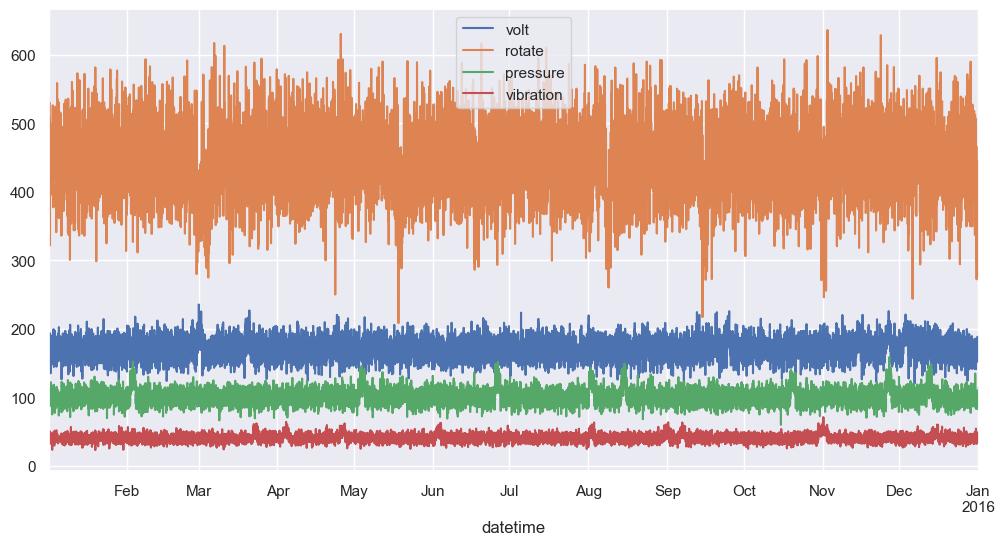

In [7]:
#Plot all the data

data.plot(figsize = (12,6))

From the plot above, we know that the vibration will be bigger when the last of the month. For the quick assumption, the anomaly of bearings' vibration may be happen mostly in last month.

<AxesSubplot:xlabel='datetime'>

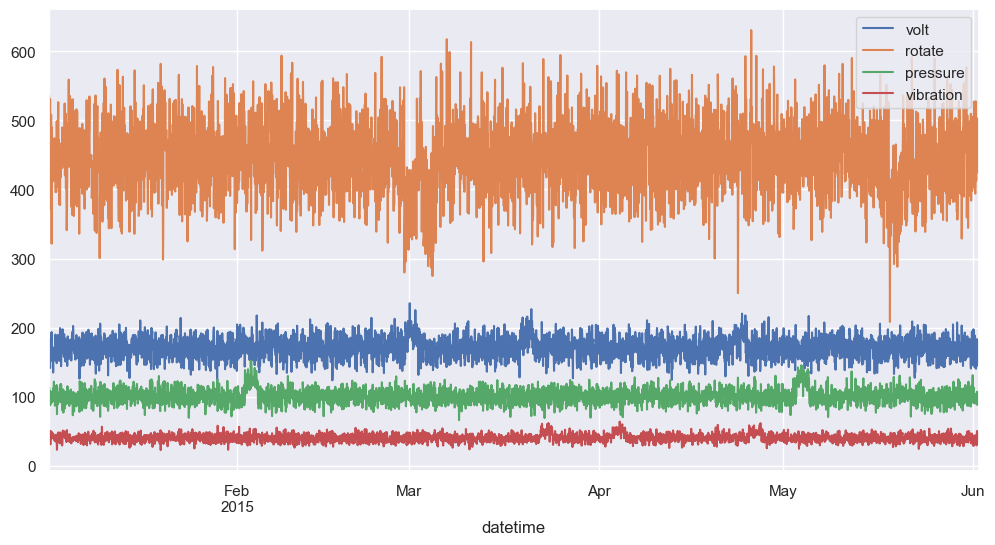

In [8]:
#Set training and testing data
#Selection of training data on that date based on a plot above that shows normal data

data_train = data[: '2015-06-01']
data_test = data['2015-06-01':]
fail_dt = fail_dt[: '2015-06-01']
data_train.plot(figsize = (12,6))

In [9]:
def plot_diagnostic_data(sen_data, fail_dt, predicted_fail_dt):
    fig, ax =  plt.subplots(figsize=(20,10))

    # Plot data
    ax.plot(sen_data['datetime'], sen_data['volt'], color='orange', label='volt')
    ax.plot(sen_data['datetime'], sen_data['rotate'], color='blue', label='rotate')
    ax.plot(sen_data['datetime'], sen_data['pressure'], color='green', label='pressure')
    ax.plot(sen_data['datetime'], sen_data['vibration'], color='black', label='vibration')

    ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
    for dt in fail_dt['datetime'][1:]:
        ax.axvline(x=dt, color='red')

    if type(predicted_fail_dt) != type(None):
        if predicted_fail_dt.empty != True:
            ax.axvline(x=predicted_fail_dt['datetime'][0], color='blue', label='predicted failure events', linestyle = '--')
            for dt in predicted_fail_dt['datetime'][1:]:
                ax.axvline(x=dt, color='blue', linestyle = '--')
        else: 
            print('\033[91m' + '\033[1m' + '-'*50 + 'EMPTY PREDICTED FAILURE DATA!' + '-'*50 + '\033[0m')

    # Format X axis - DateTime
    # date_form = DateFormatter("%m-%d")
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)

    plt.title("Sensor Measurement", fontsize = 26)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("date", fontsize = 22)
    plt.ylabel("measurement", fontsize = 22)
    plt.grid()
    plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

    plt.show()

In [10]:
#Define the function
#Normalize data

#scaler = preprocessing.MinMaxScaler()

#X_train = pd.DataFrame(scaler.fit_transform(data_train), 
#                              columns=data_train.columns, 
#                             index=data_train.index)

#X_train.sample(frac=1)

#X_test = pd.DataFrame(scaler.transform(data_test), 
#                            columns=data_test.columns, 
#                            index=data_test.index)


In [11]:
def sliding_mean(data, win_size, step_size=1):
    data_dict = {}
    
    for col_name in data.columns:
        data_dict[col_name] = []
    for col_name in data.columns:
        i = 0
        while i < (len(data)-win_size):
            if(col_name == 'datetime'):
                data_dict[col_name].append(data[col_name][i+win_size-1])
            else:   
                data_dict[col_name].append(data[col_name][i:i+win_size].mean())
            i += step_size
    
    return (pd.DataFrame(data_dict))
data_train = data_train.reset_index()
#X_train.columns
train_smooth = sliding_mean(data_train, 20, 10)
data_test = data_test.reset_index()
test_smooth =  sliding_mean(data_test, 20, 10)
fail_dt = fail_dt.reset_index()


In [12]:
train_smooth = train_smooth.reset_index()
test_smooth = test_smooth.reset_index()

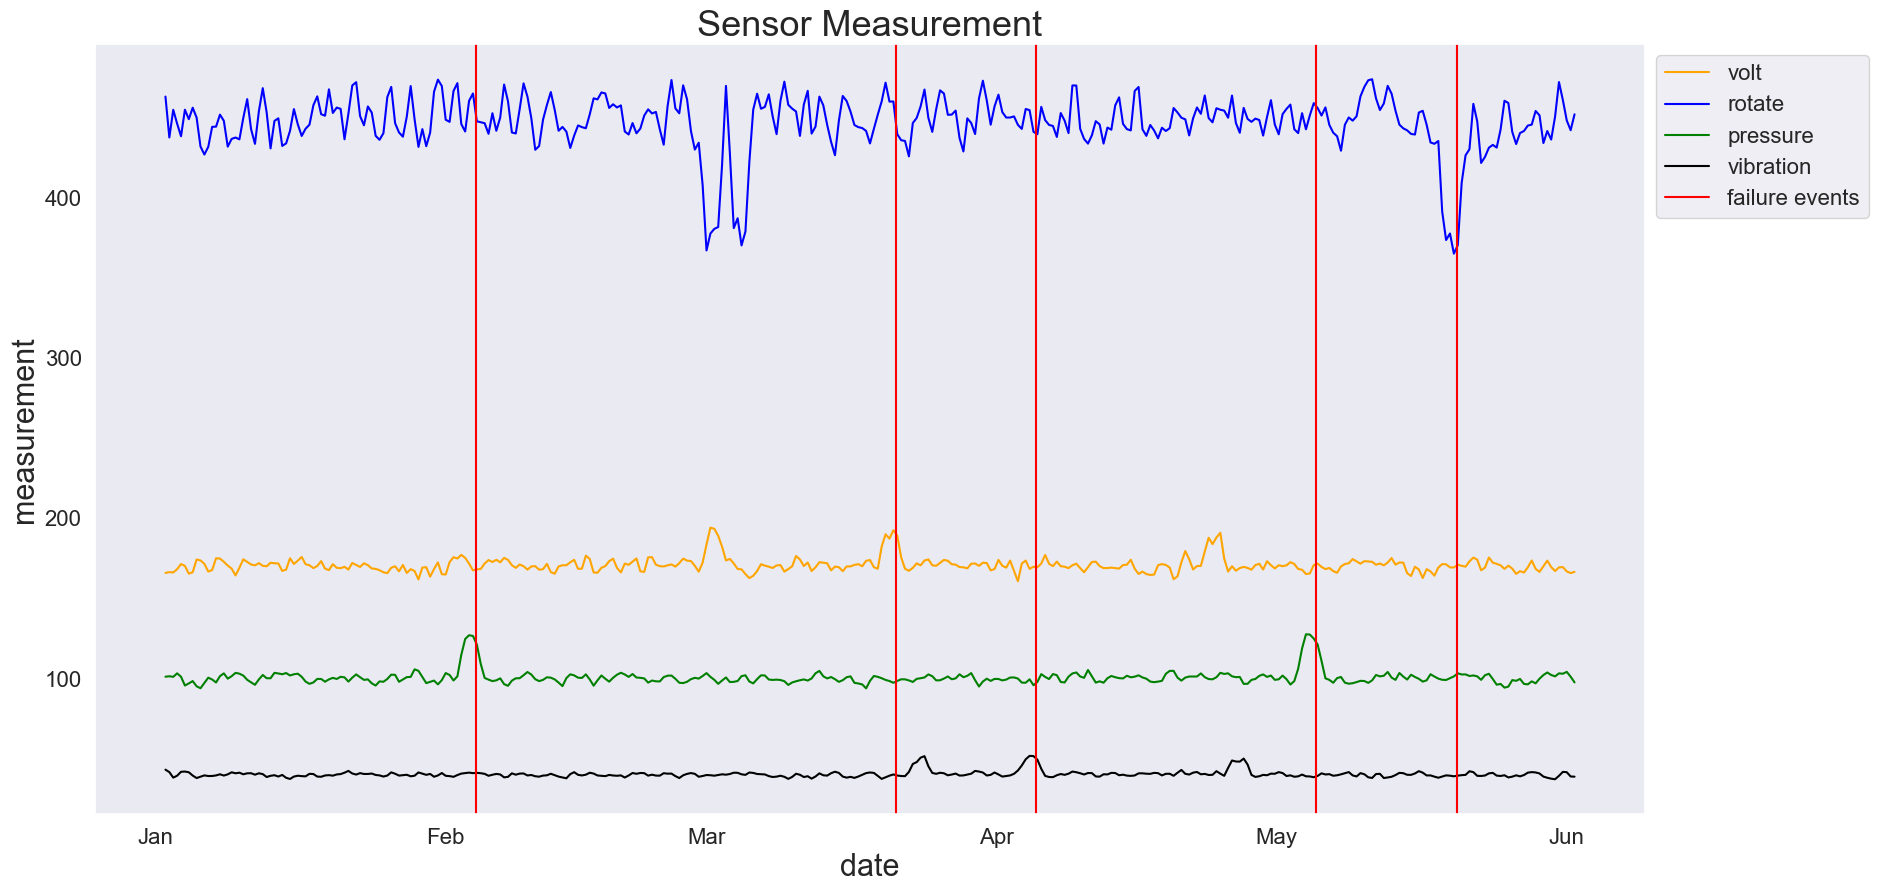

In [13]:
plot_diagnostic_data(train_smooth, fail_dt, None)

In [14]:


train_smooth

,index,datetime,volt,rotate,pressure,vibration
0,0,2015-01-02 01:00:00,165.986300,463.146618,101.252537,43.257060
1,1,2015-01-02 11:00:00,166.481762,437.660900,101.532750,41.730663
2,2,2015-01-02 21:00:00,166.287348,454.921207,101.167522,38.284306
3,3,2015-01-03 07:00:00,168.322989,446.274223,103.356567,39.485176
4,4,2015-01-03 17:00:00,171.531552,438.418174,101.218941,41.933467
...,...,...,...,...,...,...
358,358,2015-05-31 05:00:00,169.446705,472.219729,103.331776,39.413118
359,359,2015-05-31 15:00:00,169.645358,460.991659,103.114565,41.891563
360,360,2015-06-01 01:00:00,166.938468,448.263887,104.266858,41.676836
361,361,2015-06-01 11:00:00,165.866283,442.185266,101.260797,39.003229


In [15]:
X_train = train_smooth.set_index('datetime')
X_test = test_smooth.set_index('datetime')

In [16]:
#PCA to reduce the data dimension

from sklearn.decomposition import PCA
PCA = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = PCA.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = PCA.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [17]:
#Calculate the covariance matrix

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [18]:
#Calculate Mahalanobis distance

def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [19]:
#Detecting outliers

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [20]:
#Calculate threshold

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [21]:
#Check if matrix is positive definite

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [22]:
#Define PCA for training adn testing dataset

data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [23]:
#calculate covariance matrix

cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [24]:
#Calculate means for data training

mean = data_train.mean(axis=0)
mean

array([ 1.00219802e-14, -1.91043997e-14])

In [25]:
#Calculate distance for training and testing dataset and calculate threshold to detect anomaly

distance_test = MahalanobisDist(inv_cov_matrix, mean, data_test, verbose=False)
distance_train = MahalanobisDist(inv_cov_matrix, mean, data_train, verbose=False)
threshold = MD_threshold(distance_train, extreme = True)

In [26]:
threshold

3.6513724695412395

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Mahalanobis distance')

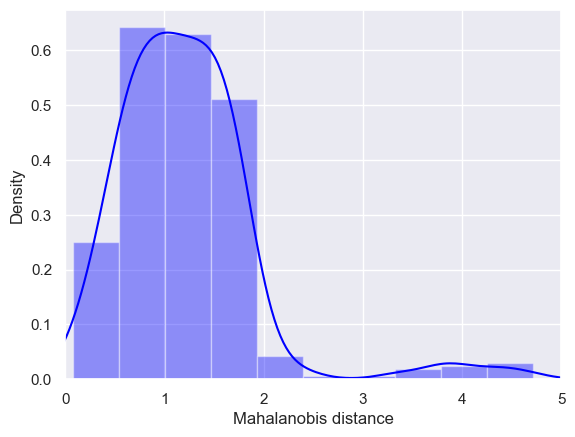

In [27]:
plt.figure()
sns.distplot(distance_train,
             bins = 10, 
             kde= True, 
            color = 'blue');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis distance')

It is proven that the day with Mahalanobis distance above 3 is outlier or anomaly.

In [28]:
anomaly_train = pd.DataFrame()
anomaly_train['Mhb dist']= distance_train
anomaly_train['Thresh'] = threshold
# If Mahalanobis distance above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mhb dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mhb dist']= distance_test
anomaly['Thresh'] = threshold
# If Mahalanobisb distance above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mhb dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mhb dist,Thresh,Anomaly
datetime,,,
2015-06-01 19:00:00,1.726200,3.651372,False
2015-06-02 05:00:00,1.718085,3.651372,False
2015-06-02 15:00:00,1.725594,3.651372,False
2015-06-03 01:00:00,1.752795,3.651372,False
2015-06-03 11:00:00,1.703631,3.651372,False


In [29]:
anomaly_train[anomaly_train['Anomaly']]

,Mhb dist,Thresh,Anomaly
datetime,,,
2015-02-28 23:00:00,4.563021,3.651372,True
2015-03-01 09:00:00,3.982223,3.651372,True
2015-03-01 19:00:00,3.816362,3.651372,True
2015-03-02 05:00:00,3.744878,3.651372,True
2015-03-03 21:00:00,3.751523,3.651372,True
2015-03-04 17:00:00,4.351162,3.651372,True
2015-03-05 03:00:00,3.855028,3.651372,True
2015-05-19 03:00:00,4.251799,3.651372,True
2015-05-19 13:00:00,4.035525,3.651372,True


In [30]:
fail_dt

,datetime
0,2015-02-04 06:00:00
1,2015-03-21 06:00:00
2,2015-04-05 06:00:00
3,2015-05-05 06:00:00
4,2015-05-20 06:00:00


In [31]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

<AxesSubplot:xlabel='datetime'>

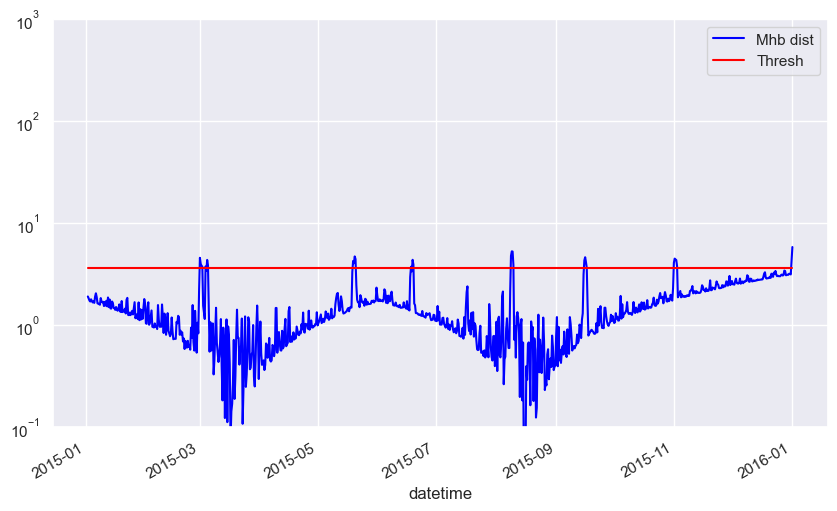

In [32]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['blue','red'])

In [33]:
anomaly_alldata.datetime = pd.to_datetime(anomaly_alldata.datetime )


AttributeError: 'DataFrame' object has no attribute 'datetime'

In [ ]:
anomaly_alldata.columns

Index(['datetime', 'Mhb dist', 'Thresh', 'Anomaly'], dtype='object')

In [ ]:
anomaly_alldata = anomaly_alldata.reset_index()

In [37]:
anomaly_alldata = anomaly_alldata.reset_index()

From the plot above proven that our quick assumption is true. The anomaly is occur almost in the last month, spesifically at 16th December 2004 afternoon.

In [34]:
from sklearn.decomposition import PCA

In [49]:
data_train['state'] = 'normal'

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [46]:
data_train['state'] = 'normal'
for dt in fail_dt['datetime']:
    for i in range(len(data_train)):
        # Find time point that was just before failure event
        if(dt < data_train['datetime'][i]):
            data_train.at[i-1, 'state'] = 'failure'
            break
            
data_train['state'].value_counts()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [38]:
X = anomaly_alldata.drop(["datetime", "Anomaly", 'Thresh'], axis = 1).values

y = anomaly_alldata["Anomaly"].values

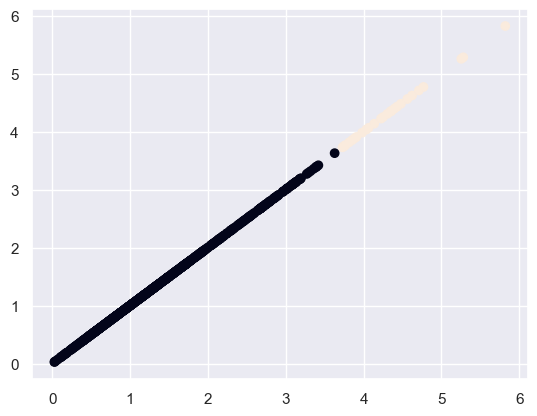

In [40]:
plt.scatter(X, X, c = y)
#plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width')

In [ ]:
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.scatter(data["SepalLengthCm"], data["SepalWidthCm"], c = y)
plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width')

plt.subplot(332)
plt.scatter(data["SepalLengthCm"], data["PetalLengthCm"], c = y)
plt.xlabel('Sepal Length'); plt.ylabel('Petal Length')

plt.subplot(333)
plt.scatter(data["SepalLengthCm"], data["PetalWidthCm"], c = y)
plt.xlabel('Sepal Length'); plt.ylabel('Petal Width')

plt.subplot(335)
plt.scatter(data["SepalWidthCm"], data["PetalLengthCm"], c = y)
plt.xlabel('Sepal Width'); plt.ylabel('Petal Length')

plt.subplot(336)
plt.scatter(data["SepalWidthCm"], data["PetalWidthCm"], c = y)
plt.xlabel('Sepal Width'); plt.ylabel('Petal Width')

plt.subplot(339)
plt.scatter(data["PetalLengthCm"], data["PetalWidthCm"], c = y)
plt.xlabel('Petal Length'); plt.ylabel('Petal Width')


plt.show()

In [ ]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print("Principal Component Analysis: ")
print("Explained variance ratio (first two components): " + str(pca.explained_variance_ratio_))
print("These two components cover " + str(round(100*sum(pca.explained_variance_ratio_) ,2)) + "% of the variance")

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print("Linear discriminant Analysis: ")
print("Explained variance ratio (first two components): " + str(lda.explained_variance_ratio_))
print("These two components cover " + str(round(100*sum(lda.explained_variance_ratio_) ,2)) + "% of the variance")

In [ ]:
plt.figure(figsize=(15,6))

colors = ['navy', 'turquoise', 'darkorange']
lw = 2

plt.subplot(121)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.subplot(122)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()